In [1]:
import math as mth
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from scipy.stats import pearsonr
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import tensorflow as tf
from scipy.stats import linregress
from datetime import datetime, timedelta
import random
import sys
import os
from io import StringIO
import json # library to handle JSON files
from matplotlib import cm,colors
from matplotlib.colors import Normalize
from geopy.geocoders import Nominatim # convert an place into latitude and longitude values
import folium # map rendering library
from bs4 import BeautifulSoup
import camelot
import requests
from IPython import get_ipython

In [2]:
import warnings

# Customize how warnings are displayed
warnings.filterwarnings('always', module='.*')
warnings.formatwarning = lambda message, category, filename, lineno, line=None: f'{category.__name__}: {message}\n'

General Classes and Functions

In [119]:
# Class to create Plots grid

from itertools import product,cycle,combinations
from scipy.stats import pearsonr
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

class Plotsgrid:

    """ Creates a nxn grid of plots for an input df. Shows blank for grid values exceeding number of columns of df"""


    def __init__(self,df):
        self.df=df 

    def figure_params(self):
        df=self.df
        n_data_cols=len(df.columns)
        self.n_data_cols=n_data_cols 

        n_cols=int(n_data_cols**.5)
        n_rows=0
        while n_rows*n_cols<n_data_cols:
            n_rows+=1
        # Create the figure and axes grid
        fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols,figsize=(int(2*n_data_cols),int(2*n_rows)))
        
        # Flatten the axs array for easier iteration
        self.axs = axs.flatten()

    # Loop through the axes and Hist plot
    def histplots(self,bins=-1):
        # Initialize figure 
        self.figure_params()
        # Create a cycler to iterate over the DataFrame columns
        cycler = cycle(self.df.columns)
        for i,ax in enumerate(self.axs):
            if i==self.n_data_cols:
                ax.set_visible(False)  # Hide any extra subplots if there are more subplots than columns
                break
            col = next(cycler)  # Get the next column name
            if bins==-1:
                sns.histplot(data=self.df, x=col, ax=ax)  # Plot the histogram on the current axis
            else:
                sns.histplot(data=self.df, x=col, ax=ax,bins=bins)  # Plot the histogram on the current axis
        plt.tight_layout()
        plt.show()

    # Loop through the axes and Box plot
    def boxplots(self):

        # Coerce df to numeric:
        df=self.df.apply(pd.to_numeric,errors='coerce').dropna(how='all',axis=1)
        
        # Initialize figure 
        self.figure_params()
        # Create a cycler to iterate over the DataFrame columns
        cycler = cycle(df.columns)
        for i,ax in enumerate(self.axs):
            try:
                if i==self.n_data_cols:
                    ax.set_visible(False)  # Hide any extra subplots if there are more subplots than columns
                    break
                col = next(cycler)  # Get the next column name
                sns.boxplot(data=df, y=col, ax=ax)  # Plot the boxplot on the current axis
            except Exception as E:
                print(E)
        plt.tight_layout()
        plt.show()

    # Loop through the axes and Line plot
    def lineplots(self):
        # Initialize figure 
        self.figure_params()
        # Create a cycler to iterate over the DataFrame columns
        cycler = cycle(self.df.columns)
        for i,ax in enumerate(self.axs):
            if i==self.n_data_cols:
                ax.set_visible(False)  # Hide any extra subplots if there are more subplots than columns
                break
            col = next(cycler)  # Get the next column name
            sns.lineplot(data=self.df,x=self.df.index,y=col, ax=ax)  # Plot the Line on the current axis
        plt.tight_layout()
        plt.show()

    def scatterplots(self):

        # Coerce df to numeric:
        df=self.df.apply(pd.to_numeric,errors='coerce').dropna(how='all',axis=1)
        
        # Get all numeric combinations
        col_combinations = list(combinations(df.columns, 2))
        num_combs = len(col_combinations)
        
        # Calculate grid size based on the number of combinations
        n_cols = int(np.ceil(np.sqrt(num_combs)))
        n_rows = int(np.ceil(num_combs / n_cols))

        # Create the figure and axes grid
        fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(int(2*n_cols),int(2*n_rows)))
        plt.suptitle('Pairwise Scatter with higher correlations shown brighter')
        axs = axs.flatten()  # Flatten the axes array for easier iteration

        # Iterate through each combination and plot scatterplots
        for i, (col_x, col_y) in enumerate(col_combinations):
            ax = axs[i]

            df_x_y=df[[col_x,col_y]].dropna()

            x = df_x_y[col_x]
            y = df_x_y[col_y]

            # Calculate Pearson correlation and p-value
            if len(x) > 1 and len(y) > 1:  # Ensure there are enough data points
                corr, p_value = pearsonr(x, y)
                corr_array=np.array([corr]*x.shape[0])
                # Scatter plot with colored points
                sns.scatterplot(x=x, y=y, ax=ax,hue=corr_array, palette='coolwarm',hue_norm=(-1,1),legend=False)

                # Add correlation coefficient and p-value as the legend
                ax.text(0.05, 0.95, f"r = {corr:.2f}\np = {p_value:.2e}", 
                        transform=ax.transAxes, fontsize=7, verticalalignment='top',
                        bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", edgecolor="black"))
                
                # Set plot labels
                ax.set_xlabel(col_x)
                ax.set_ylabel(col_y)

        # Hide any extra subplots
        for j in range(i + 1, len(axs)):
            axs[j].set_visible(False)
        plt.tight_layout()
        plt.show()

### Air Quality by City

In [4]:
# Air quality by City
filename = 'AQI_Bulletin_20240820.xlsx'
sheet='Table 1'

df_aqi = pd.read_excel(filename)

Pre-processing

In [5]:
df_aqi.shape

(237, 9)

In [6]:
# Print the first few rows
df_aqi.head()

,S.No,City,Unnamed: 2,Unnamed: 3,Air Quality,Unnamed: 5,Index Value,Prominent Pollutant,No. of Stations Participated/ Total Stations
0,1,Agartala,NaN,NaN,Good,NaN,36,PM10,1/2
1,2,Agra,NaN,NaN,Good,NaN,31,"SO2, NO2, PM10",6/6
2,3,Ahmedabad,NaN,NaN,Satisfactory,NaN,75,"PM2.5, PM10",8/9
3,4,Ahmednagar,NaN,NaN,Good,NaN,38,PM10,1/1
4,5,Aizawl,NaN,NaN,Good,NaN,22,O3,1/1


In [7]:
df_aqi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 237 entries, 0 to 236
Data columns (total 9 columns):
 #   Column                                        Non-Null Count  Dtype 
---  ------                                        --------------  ----- 
 0   S.No                                          229 non-null    object
 1   City                                          228 non-null    object
 2   Unnamed: 2                                    7 non-null      object
 3   Unnamed: 3                                    7 non-null      object
 4   Air Quality                                   229 non-null    object
 5   Unnamed: 5                                    7 non-null      object
 6   Index Value                                   228 non-null    object
 7   Prominent Pollutant                           228 non-null    object
 8   No. of Stations Participated/ Total Stations  228 non-null    object
dtypes: object(9)
memory usage: 16.8+ KB


In [8]:
# Drop null values from Index Value
df_aqi.dropna(subset=['Index Value']).info()

<class 'pandas.core.frame.DataFrame'>
Index: 228 entries, 0 to 227
Data columns (total 9 columns):
 #   Column                                        Non-Null Count  Dtype 
---  ------                                        --------------  ----- 
 0   S.No                                          228 non-null    object
 1   City                                          228 non-null    object
 2   Unnamed: 2                                    0 non-null      object
 3   Unnamed: 3                                    0 non-null      object
 4   Air Quality                                   228 non-null    object
 5   Unnamed: 5                                    0 non-null      object
 6   Index Value                                   228 non-null    object
 7   Prominent Pollutant                           228 non-null    object
 8   No. of Stations Participated/ Total Stations  228 non-null    object
dtypes: object(9)
memory usage: 17.8+ KB


We are only interested in numeric types for Index Value. Trying to coerce the dtype for the column to numeric creates an exception due to some of the values being string. We can explore what the string values are

In [9]:
# Print unique string values
df_aqi['Index Value'].apply(lambda x:x if type(x)==str else '').unique()

array(['', 'Index Value'], dtype=object)

Looks like 'Index Value' is the non-numeric field. Let's print rows of this value

In [10]:
df_aqi[df_aqi['Index Value']=='Index Value']

,S.No,City,Unnamed: 2,Unnamed: 3,Air Quality,Unnamed: 5,Index Value,Prominent Pollutant,No. of Stations Participated/ Total Stations
20,S.No,City,NaN,NaN,Air Quality,NaN,Index Value,Prominent Pollutant,No. of Stations Participated/ Total Stations
41,S.No,City,NaN,NaN,Air Quality,NaN,Index Value,Prominent Pollutant,No. of Stations Participated/ Total Stations
62,S.No,City,NaN,NaN,Air Quality,NaN,Index Value,Prominent Pollutant,No. of Stations Participated/ Total Stations
83,S.No,City,NaN,NaN,Air Quality,NaN,Index Value,Prominent Pollutant,No. of Stations Participated/ Total Stations
104,S.No,City,NaN,NaN,Air Quality,NaN,Index Value,Prominent Pollutant,No. of Stations Participated/ Total Stations
125,S.No,City,NaN,NaN,Air Quality,NaN,Index Value,Prominent Pollutant,No. of Stations Participated/ Total Stations
146,S.No,City,NaN,NaN,Air Quality,NaN,Index Value,Prominent Pollutant,No. of Stations Participated/ Total Stations
167,S.No,City,NaN,NaN,Air Quality,NaN,Index Value,Prominent Pollutant,No. of Stations Participated/ Total Stations
188,S.No,City,NaN,NaN,Air Quality,NaN,Index Value,Prominent Pollutant,No. of Stations Participated/ Total Stations
209,S.No,City,NaN,NaN,Air Quality,NaN,Index Value,Prominent Pollutant,No. of Stations Participated/ Total Stations


Gives us also bad values for 'City', 'Air Quality', 'Prominent Pollutant' and 'No. of Stations Participated/ Total Stations'. So we can drop the rows corresponding to 'Index Value'

In [11]:
df_aqi=df_aqi[df_aqi['Index Value']!='Index Value']
# Check for nan values in index value
df_aqi[df_aqi['Index Value'].isna()]

,S.No,City,Unnamed: 2,Unnamed: 3,Air Quality,Unnamed: 5,Index Value,Prominent Pollutant,No. of Stations Participated/ Total Stations
228,Cities absent in AQI Bulletin due to insuffici...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
229,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
230,NaN,NaN,AQI,Category,Color Code,Possible Health Impacts,NaN,NaN,NaN
231,NaN,NaN,0-50,Good,NaN,Minimal Impact,NaN,NaN,NaN
232,NaN,NaN,51-100,Satisfactory,NaN,Minor breathing discomfort to sensitive people,NaN,NaN,NaN
233,NaN,NaN,101-200,Moderate,NaN,"Breathing discomfort to the people with lungs,...",NaN,NaN,NaN
234,NaN,NaN,201-300,Poor,NaN,Breathing discomfort to most people on prolong...,NaN,NaN,NaN
235,NaN,NaN,301-400,Very Poor,NaN,Respiratory illness on prolonged exposure,NaN,NaN,NaN
236,NaN,NaN,401-500,Severe,NaN,Affects healthy people and seriously impacts t...,NaN,NaN,NaN


In [12]:
# It is safe to drop the rows that have NAN index value
df_aqi=df_aqi.dropna(subset=['Index Value'])
# try to coerce df_aqi index value to numeric
df_aqi['Index Value']=df_aqi['Index Value'].astype(int)

In [13]:
# Print info and stats
df_aqi['Index Value'].describe()

count    218.000000
mean      56.958716
std       21.772243
min       11.000000
25%       42.000000
50%       54.000000
75%       67.750000
max      141.000000
Name: Index Value, dtype: float64

Lets explore the columns again

In [14]:
# Print the info
df_aqi.info()

<class 'pandas.core.frame.DataFrame'>
Index: 218 entries, 0 to 227
Data columns (total 9 columns):
 #   Column                                        Non-Null Count  Dtype 
---  ------                                        --------------  ----- 
 0   S.No                                          218 non-null    object
 1   City                                          218 non-null    object
 2   Unnamed: 2                                    0 non-null      object
 3   Unnamed: 3                                    0 non-null      object
 4   Air Quality                                   218 non-null    object
 5   Unnamed: 5                                    0 non-null      object
 6   Index Value                                   218 non-null    int32 
 7   Prominent Pollutant                           218 non-null    object
 8   No. of Stations Participated/ Total Stations  218 non-null    object
dtypes: int32(1), object(8)
memory usage: 16.2+ KB


In [15]:
# First few rows again
df_aqi.head()

,S.No,City,Unnamed: 2,Unnamed: 3,Air Quality,Unnamed: 5,Index Value,Prominent Pollutant,No. of Stations Participated/ Total Stations
0,1,Agartala,NaN,NaN,Good,NaN,36,PM10,1/2
1,2,Agra,NaN,NaN,Good,NaN,31,"SO2, NO2, PM10",6/6
2,3,Ahmedabad,NaN,NaN,Satisfactory,NaN,75,"PM2.5, PM10",8/9
3,4,Ahmednagar,NaN,NaN,Good,NaN,38,PM10,1/1
4,5,Aizawl,NaN,NaN,Good,NaN,22,O3,1/1


Looks like removing nans from index value removed a lot of the bad data from other columns as well, including City. For our purposes we only need the 'City' and Index Value.

In [16]:
df_aqi_city_index=df_aqi[['City','Index Value']]

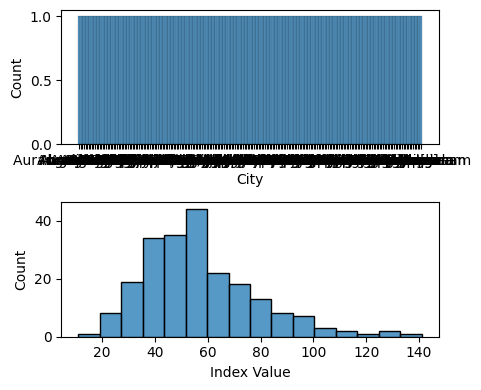

In [17]:
# Hist Plots
Plotsgrid(df_aqi_city_index).histplots()

Create Geolocator using Nominatim and Obtain Location info. for the places

In [18]:
geoagent="explorer"
geolocator = Nominatim(user_agent=geoagent)

In [19]:
lat_list=[]
lon_list=[]
cities=df_aqi_city_index.City.tolist()
for city in cities:
    try:
        loc = geolocator.geocode(city)
        lat_list.append(loc.latitude)
        lon_list.append(loc.longitude)
    except Exception as E:
        print(E)
        lat_list.append(np.nan)
        lon_list.append(np.nan)
        
df_aqi_city_index['latitude']=lat_list
df_aqi_city_index['longitude']=lon_list



'NoneType' object has no attribute 'latitude'
'NoneType' object has no attribute 'latitude'
'NoneType' object has no attribute 'latitude'
'NoneType' object has no attribute 'latitude'


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [20]:
# Explore nan atitude and longitudes
df_aqi_city_index[(df_aqi_city_index['latitude'].isna())|(df_aqi_city_index['longitude'].isna())]

,City,Index Value,latitude,longitude
49,Bileipada,81,NaN,NaN
136,Kunjemura,71,NaN,NaN
164,Palkalaiperur,11,NaN,NaN
204,Suakati,32,NaN,NaN


There are just four cities with no location information. We can drop these

In [21]:
df_aqi_city_index=df_aqi_city_index[(df_aqi_city_index['latitude'].isna()==False)&(df_aqi_city_index['longitude'].isna()==False)].reset_index(drop=True)

In [22]:
df_aqi_city_index.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   City         214 non-null    object 
 1   Index Value  214 non-null    int32  
 2   latitude     214 non-null    float64
 3   longitude    214 non-null    float64
dtypes: float64(2), int32(1), object(1)
memory usage: 6.0+ KB


In [23]:
df_aqi_city_index.head()

,City,Index Value,latitude,longitude
0,Agartala,36,23.831238,91.282382
1,Agra,31,27.175255,78.009816
2,Ahmedabad,75,23.021537,72.580057
3,Ahmednagar,38,19.162773,74.858024
4,Aizawl,22,23.743353,92.738276


In [24]:
# Location for country
country='India'
country_loc=geolocator.geocode(country)
latitude=country_loc.latitude
longitude=country_loc.longitude
latitude,longitude

(22.3511148, 78.6677428)

In [25]:
# Rename some columns:
df_aqi_city_index.rename(columns={'Index Value':'City AQI','latitude':'City latitude','longitude':'City longitude'},inplace=True)

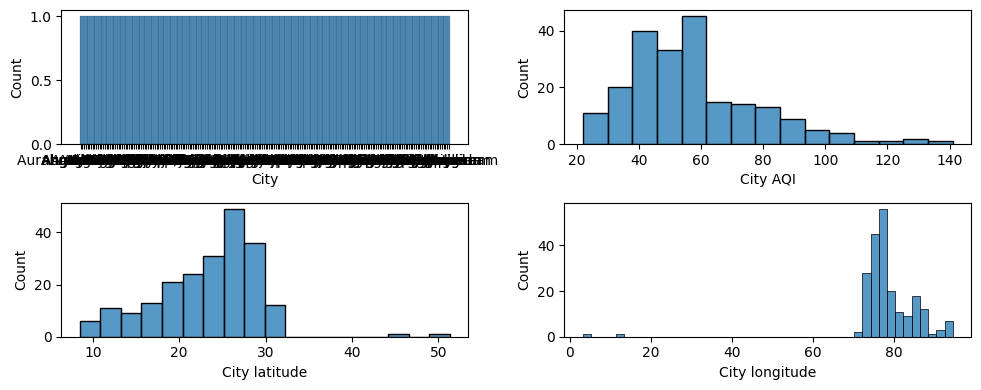

In [26]:
# Histograms
Plotsgrid(df_aqi_city_index).histplots()

Plot on Map

In [27]:
maps={}
map_clusters = folium.Map(location=[latitude, longitude],zoom_start=5)

# Define a colormap using matplotlib
colormap = plt.get_cmap('YlOrRd')  # You can choose any colormap from matplotlib

# Normalize index values to range [0, 1] for the colormap
norm = Normalize(vmin=df_aqi_city_index['City AQI'].min(), vmax=df_aqi_city_index['City AQI'].max())

# add markers to the map
markers_colors = []

for index,row in df_aqi_city_index.iterrows():

    name,index_val,lat,lon=row['City'],row['City AQI'],row['City latitude'],row['City longitude']
    label = folium.Popup(f"{name}, Index Value: {index_val}", parse_html=True)

    # Get color from colormap
    rgba_color = colormap(norm(index_val))  # This returns an RGBA tuple
    hex_color = colors.rgb2hex(rgba_color[:3])  # Convert to hex

    folium.CircleMarker(
        [lat, lon],
        radius=7,
        popup=label,
        color=hex_color,
        fill=True,
        fill_color=hex_color,
        fill_opacity=0.7,
                        ).add_to(map_clusters)

map_clusters


<b> Observations: </b>
<li> The highest AQI (maximum pollution) occurs in the North west and towards the east.
<li> Southern cities have in general better AQI

## Import Population information

In [28]:
# Specify Link 
population_url = 'https://nriol.com/india-statistics/biggest-cities-india.asp'

# Set headers to include a user-agent
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'
}

# Fetch the HTML content
response = requests.get(population_url, headers=headers)
html_content = response.text

# Use StringIO to wrap the HTML content
html_content_io = StringIO(html_content)

# Use pandas to read the tables from the HTML content
df_pop_list = pd.read_html(html_content_io)

# Display each table
for frame in df_pop_list:
    print(frame.head())

   Serial no. Indian Cities Indian States Population Density(/km2) Literacy  \
0           1        Mumbai   Maharashtra   12442373           NaN   89.73%   
1           2         Delhi         Delhi   16787941           NaN   86.20%   
2           3     Bangalore     Karnataka    8443675         12000   88.71%   
3           4     Hyderabad     Telangana    6731790         10477   83.26%   
4           5     Ahmedabad       Gujarat    5577940         11000   89.62%   

  *Sex Ratio Main Language  
0        853       Marathi  
1        868         Hindi  
2        923       Kannada  
3        955        Telugu  
4        898      Gujarati  


In [29]:
# Create the population dataframe from the pop df
df_pop=pd.DataFrame()
for frame in df_pop_list:
    df_pop=pd.concat([df_pop,frame],axis=0)
df_pop.head()

,Serial no.,Indian Cities,Indian States,Population,Density(/km2),Literacy,*Sex Ratio,Main Language
0,1,Mumbai,Maharashtra,12442373,NaN,89.73%,853,Marathi
1,2,Delhi,Delhi,16787941,NaN,86.20%,868,Hindi
2,3,Bangalore,Karnataka,8443675,12000,88.71%,923,Kannada
3,4,Hyderabad,Telangana,6731790,10477,83.26%,955,Telugu
4,5,Ahmedabad,Gujarat,5577940,11000,89.62%,898,Gujarati


In [30]:
# Try coercing Population and Density to numeric
df_pop['Population']=pd.to_numeric(df_pop['Population'],errors='coerce')
df_pop['Density(/km2)']=pd.to_numeric(df_pop['Density(/km2)'],errors='coerce')

In [31]:
# Inspect the nans for population and density
df_pop[(df_pop['Population'].isna())|(df_pop['Density(/km2)'].isna())]

,Serial no.,Indian Cities,Indian States,Population,Density(/km2),Literacy,*Sex Ratio,Main Language
0,1,Mumbai,Maharashtra,12442373.0,NaN,89.73%,853,Marathi
1,2,Delhi,Delhi,16787941.0,NaN,86.20%,868,Hindi
5,6,Chennai,Tamil Nadu,NaN,17000.0,90.20%,989,Tamil
7,8,Surat,Gujarat,4467797.0,NaN,87.90%,756,Gujarati
10,11,Lucknow,Uttar Pradesh,2817105.0,NaN,82.50%,940,Hindi
11,12,Kanpur,Uttar Pradesh,2765348.0,NaN,82.42%,857,Hindi
32,33,Dhanbad,Jharkhand,NaN,2000.0,79.47%,891,"Hindi , English"
35,36,Allahabad,Uttar Pradesh,1168385.0,NaN,84.76%,853,Hindi
37,38,Haora,West Bengal,1077075.0,NaN,91.47%,919,Bengali
39,40,Jabalpur,Maharashtra,NaN,3390.0,87.39Â %.,935,Hindi


In [32]:
# Manually fill in the missing population and density values
df_pop.loc[df_pop['Indian Cities'] == 'Chennai', 'Population'] = 7090000
df_pop.loc[df_pop['Indian Cities'] == 'Surat', 'Density(/km2)'] = 13600
df_pop.loc[df_pop['Indian Cities'] == 'Lucknow', 'Density(/km2)'] = 8000
df_pop.loc[df_pop['Indian Cities'] == 'Kanpur', 'Density(/km2)'] = 6300
df_pop.loc[df_pop['Indian Cities'] == 'Dhanbad', 'Population'] = 1160000
df_pop.loc[df_pop['Indian Cities'] == 'Allahabad', 'Density(/km2)'] = 9800
df_pop.loc[df_pop['Indian Cities'] == 'Haora', 'Density(/km2)'] = 11000
df_pop.loc[df_pop['Indian Cities'] == 'Jabalpur', 'Population'] = 1240000
df_pop.loc[df_pop['Indian Cities'] == 'Jabalpur', 'Density(/km2)'] = 4000
df_pop.loc[df_pop['Indian Cities'] == 'Guwahati', 'Density(/km2)'] = 4300
df_pop.loc[df_pop['Indian Cities'] == 'Chandigarh', 'Density(/km2)'] = 9258
df_pop.loc[df_pop['Indian Cities'] == 'Solapur', 'Density(/km2)'] = 6120
df_pop.loc[df_pop['Indian Cities'] == 'Tiruchirappalli', 'Population'] = 916857
df_pop.loc[df_pop['Indian Cities'] == 'Bhubaneswar', 'Population'] = 881988
df_pop.loc[df_pop['Indian Cities'] == 'Kochi', 'Density(/km2)'] = 6320
df_pop.loc[df_pop['Indian Cities'] == 'Loni', 'Density(/km2)'] = 3650
df_pop.loc[df_pop['Indian Cities'] == 'Siliguri', 'Density(/km2)'] = 9400
df_pop.loc[df_pop['Indian Cities'] == 'Nellore', 'Density(/km2)'] = 6784
df_pop.loc[df_pop['Indian Cities'] == 'Maheshtala', 'Density(/km2)'] = 13200
df_pop.loc[df_pop['Indian Cities'] == 'Mumbai', 'Density(/km2)'] = 20600
df_pop.loc[df_pop['Indian Cities'] == 'Delhi', 'Density(/km2)'] = 11320

# Inspect the nans for population and density
df_pop[(df_pop['Population'].isna())|(df_pop['Density(/km2)'].isna())]


,Serial no.,Indian Cities,Indian States,Population,Density(/km2),Literacy,*Sex Ratio,Main Language
52,53,Karnataka,893062,5857.0,NaN,999,Kannada,NaN


In [33]:
# Karnataka is not a city so drop
df_pop=df_pop[df_pop['Indian Cities']!='Karnataka']
# Inspect the nans for population and density
df_pop[(df_pop['Population'].isna())|(df_pop['Density(/km2)'].isna())]

,Serial no.,Indian Cities,Indian States,Population,Density(/km2),Literacy,*Sex Ratio,Main Language


In [34]:
# Add City area based on Population/Density=Area. 
df_pop.dropna(subset=['Population','Density(/km2)'],inplace=True)
df_pop['Population']=df_pop['Population'].astype(int)
df_pop['Density(/km2)']=df_pop['Density(/km2)'].astype(int)
df_pop['City Area']=df_pop['Population']/df_pop['Density(/km2)']

In [35]:
#We don't need Literacy, sex ratio and main language for our analysis
# Rename columns
df_pop.rename(columns={'Indian Cities':'City', 'Indian States':'State', 'Population':'City Population','Density(/km2)':'City Population Density'},inplace=True)
df_pop=df_pop[['City','State','City Area','City Population','City Population Density']]
df_pop.info()

<class 'pandas.core.frame.DataFrame'>
Index: 99 entries, 0 to 99
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   City                     99 non-null     object 
 1   State                    99 non-null     object 
 2   City Area                99 non-null     float64
 3   City Population          99 non-null     int32  
 4   City Population Density  99 non-null     int32  
dtypes: float64(1), int32(2), object(2)
memory usage: 3.9+ KB


In [36]:
df_pop.head()

,City,State,City Area,City Population,City Population Density
0,Mumbai,Maharashtra,603.998689,12442373,20600
1,Delhi,Delhi,1483.033657,16787941,11320
2,Bangalore,Karnataka,703.639583,8443675,12000
3,Hyderabad,Telangana,642.530304,6731790,10477
4,Ahmedabad,Gujarat,507.085455,5577940,11000


In [37]:
df_pop['City Area']=df_pop['City Area'].astype(int)

In [38]:
df_pop.head()

,City,State,City Area,City Population,City Population Density
0,Mumbai,Maharashtra,603,12442373,20600
1,Delhi,Delhi,1483,16787941,11320
2,Bangalore,Karnataka,703,8443675,12000
3,Hyderabad,Telangana,642,6731790,10477
4,Ahmedabad,Gujarat,507,5577940,11000


## Factory Information

In [39]:
fac_filename='india_factory.csv'
df_fac=pd.read_csv(fac_filename)
df_fac.head()

,Sr. No,State/Union Territory,On register at the beginning of the year,Newly registered during the year,Removed from the register during the year,On Register at the end of the year,Working on any day during the year,Submitting returns,Percentage Response
0,1,A. & N. Islands,48,6,6,42,42,26,61.90
1,2,Andhra Pradesh,25292,1632,1665,25259,19326,5448,28.19
2,3,Assam,6945,296,16,7225,6133,286,4.66
3,4,Bihar,7972,160,3,8129,6170,102,12.80
4,5,Chandigarh,413,7,1,412,412,52,12.62


We are more interested in the 'State/Union Terrtory' and 'On Register at the end of year'. First lets convert these column names to something more readable

In [40]:
df_fac.rename(columns={'State/Union Territory':'State','Working on any day during the year':'Num of Factories in State'},inplace=True)
df_fac=df_fac[['State','Num of Factories in State']]
df_fac.head()

,State,Num of Factories in State
0,A. & N. Islands,42
1,Andhra Pradesh,19326
2,Assam,6133
3,Bihar,6170
4,Chandigarh,412


## Combine the AQI, Population and Factories information

We can combine Population and factories info on state, then the combined table with AQI on city.

In [41]:
# 'State' values for population and factories information
print(sorted(df_pop.State.unique().tolist()))
print(sorted(df_fac.State.unique().tolist()))

['Assam', 'Bihar', 'Chhattisgarh', 'Delhi', 'Gujarat', 'Haryana', 'Jammu & Kashmir', 'Jharkhand', 'Karnataka', 'Kerala', 'Madhya Pradesh', 'Maharashtra', 'Orissa', 'Punjab', 'Rajasthan', 'Seemandhra', 'Tamil Nadu', 'Telangana', 'Uttar Pradesh', 'Uttarakhand', 'West Bengal']
['A. & N. Islands', 'Andhra Pradesh', 'Assam', 'Bihar', 'Chandigarh', 'Chhattisgarh', 'Daman & Diu and Dadra & Nagar Haveli', 'Goa', 'Gujarat', 'Haryana', 'Himachal Pradesh', 'Jammu & Kashmir', 'Jharkhand', 'Kerala', 'Manipur', 'Meghalaya', 'Nagaland', 'Puducherry', 'Rajasthan', 'Tamil Nadu', 'Telangana', 'Tripura', 'Uttarakhand']


In [42]:
df_pop_fac=df_pop.merge(df_fac,on='State',how='outer')
df_pop_fac

,City,State,City Area,City Population,City Population Density,Num of Factories in State
0,NaN,A. & N. Islands,NaN,NaN,NaN,42.0
1,NaN,Andhra Pradesh,NaN,NaN,NaN,19326.0
2,Guwahati,Assam,222.0,957352.0,4300.0,6133.0
3,Patna,Bihar,99.0,1684222.0,17012.0,6170.0
4,Gaya,Bihar,49.0,468614.0,9490.0,6170.0
...,...,...,...,...,...,...
105,Haora,West Bengal,97.0,1077075.0,11000.0,NaN
106,Durgapur,West Bengal,149.0,566517.0,3800.0,NaN
107,Asansol,West Bengal,161.0,563917.0,3500.0,NaN
108,Siliguri,West Bengal,54.0,513264.0,9400.0,NaN


In [43]:
# Merge the AQI and pop_fac tables
df=df_pop_fac.merge(df_aqi_city_index,on='City',how='right')
df

,City,State,City Area,City Population,City Population Density,Num of Factories in State,City AQI,City latitude,City longitude
0,Agartala,NaN,NaN,NaN,NaN,NaN,36,23.831238,91.282382
1,Agra,Uttar Pradesh,1462.0,1585704.0,1084.0,NaN,31,27.175255,78.009816
2,Ahmedabad,Gujarat,507.0,5577940.0,11000.0,35339.0,75,23.021537,72.580057
3,Ahmednagar,NaN,NaN,NaN,NaN,NaN,38,19.162773,74.858024
4,Aizawl,NaN,NaN,NaN,NaN,NaN,22,23.743353,92.738276
...,...,...,...,...,...,...,...,...,...
209,Vijayawada,Seemandhra,60.0,1034358.0,17000.0,NaN,54,16.508757,80.618509
210,Virar,NaN,NaN,NaN,NaN,NaN,85,19.449800,72.812061
211,Visakhapatnam,Seemandhra,691.0,1728128.0,2500.0,NaN,63,17.723128,83.301284
212,Vrindavan,NaN,NaN,NaN,NaN,NaN,83,27.575373,77.693804


In [44]:
# Make another column for State averaged AQI to compare AQI with state level info

# Group by 'State' and calculate the average of 'Index Value' (AQI)
state_avg_aqi = df.groupby('State')['City AQI'].mean().reset_index()

# Rename the column for clarity
state_avg_aqi.columns = ['State', 'State_Avg_AQI']

# Merge the state-level average AQI back into the original DataFrame
df=pd.merge(df, state_avg_aqi, on='State', how='left')

# Display the updated DataFrame
df.head()

,City,State,City Area,City Population,City Population Density,Num of Factories in State,City AQI,City latitude,City longitude,State_Avg_AQI
0,Agartala,NaN,NaN,NaN,NaN,NaN,36,23.831238,91.282382,NaN
1,Agra,Uttar Pradesh,1462.0,1585704.0,1084.0,NaN,31,27.175255,78.009816,48.083333
2,Ahmedabad,Gujarat,507.0,5577940.0,11000.0,35339.0,75,23.021537,72.580057,71.000000
3,Ahmednagar,NaN,NaN,NaN,NaN,NaN,38,19.162773,74.858024,NaN
4,Aizawl,NaN,NaN,NaN,NaN,NaN,22,23.743353,92.738276,NaN


Make plots

In [45]:
# Numeric columns
df_numeric=df.select_dtypes(include=['number'])

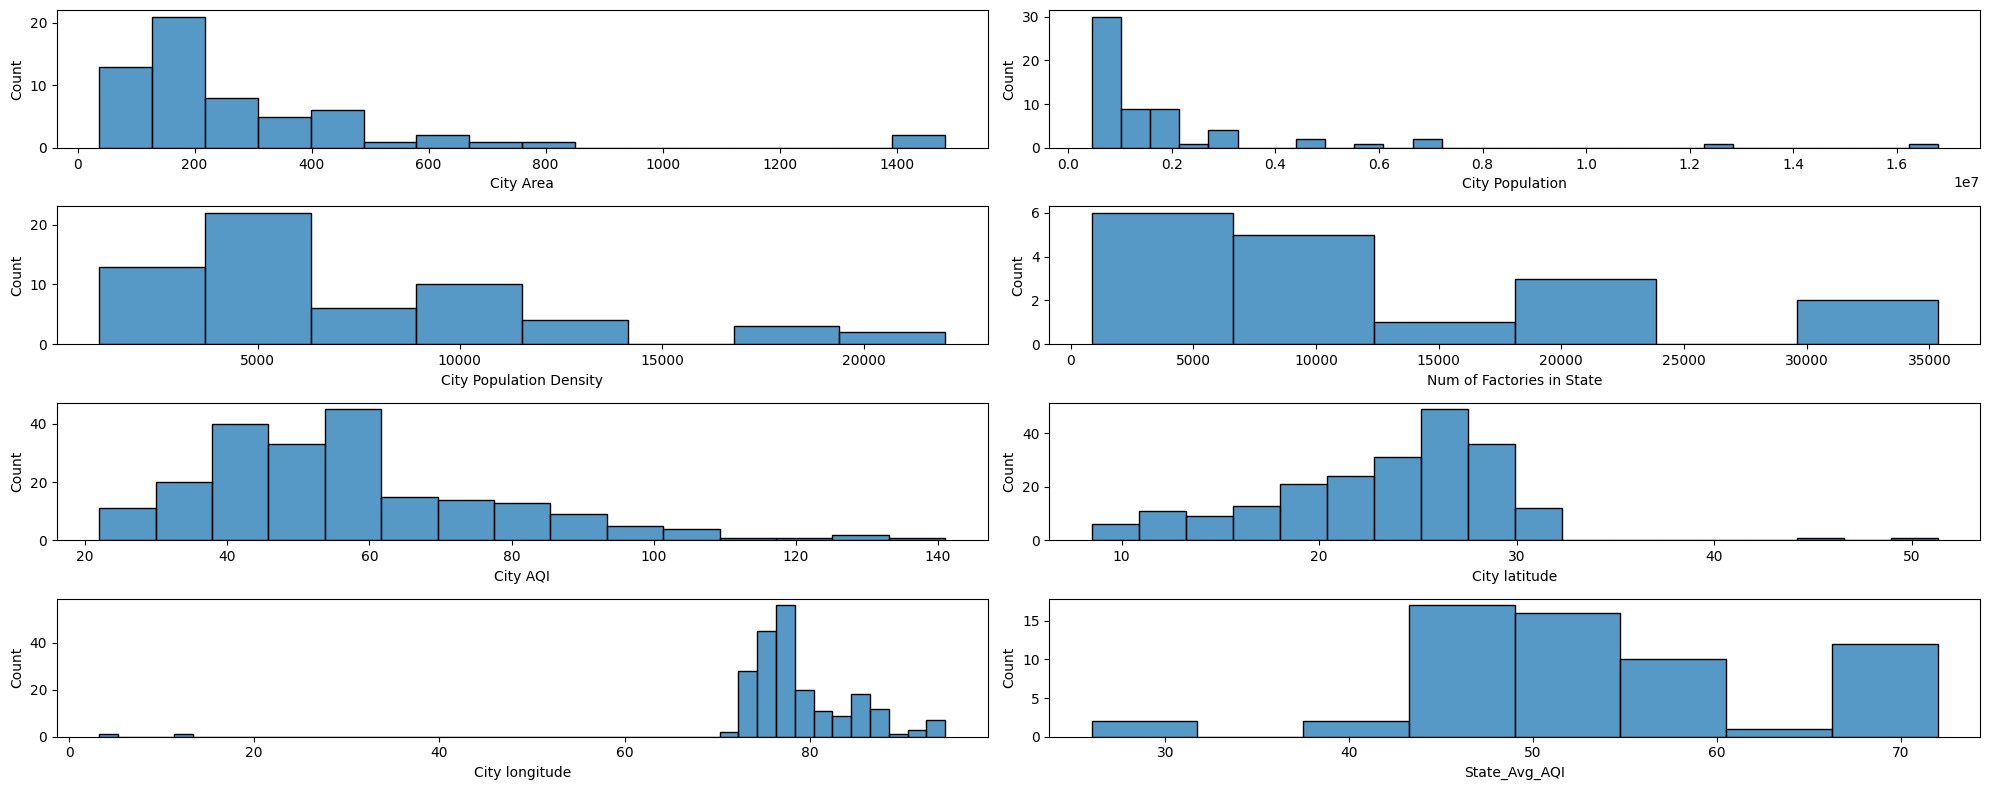

In [46]:
# Hist Plots
Plotsgrid(df_numeric).histplots()

<li> State Average AQI has an almost normal distribution, suggesting that good or bad AQI is not characteristic of the state as a whole, but is more a regional city-level characteristic

<Axes: >

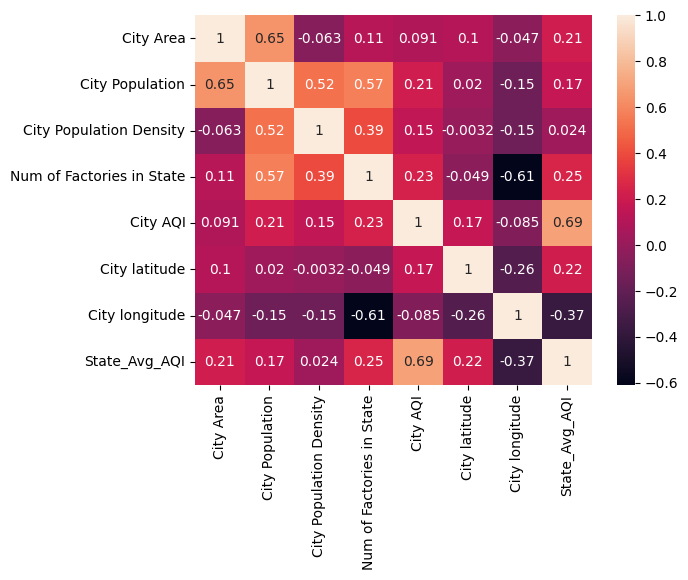

In [48]:
# Correlation Plot
sns.heatmap(df_numeric.corr(),annot=True)

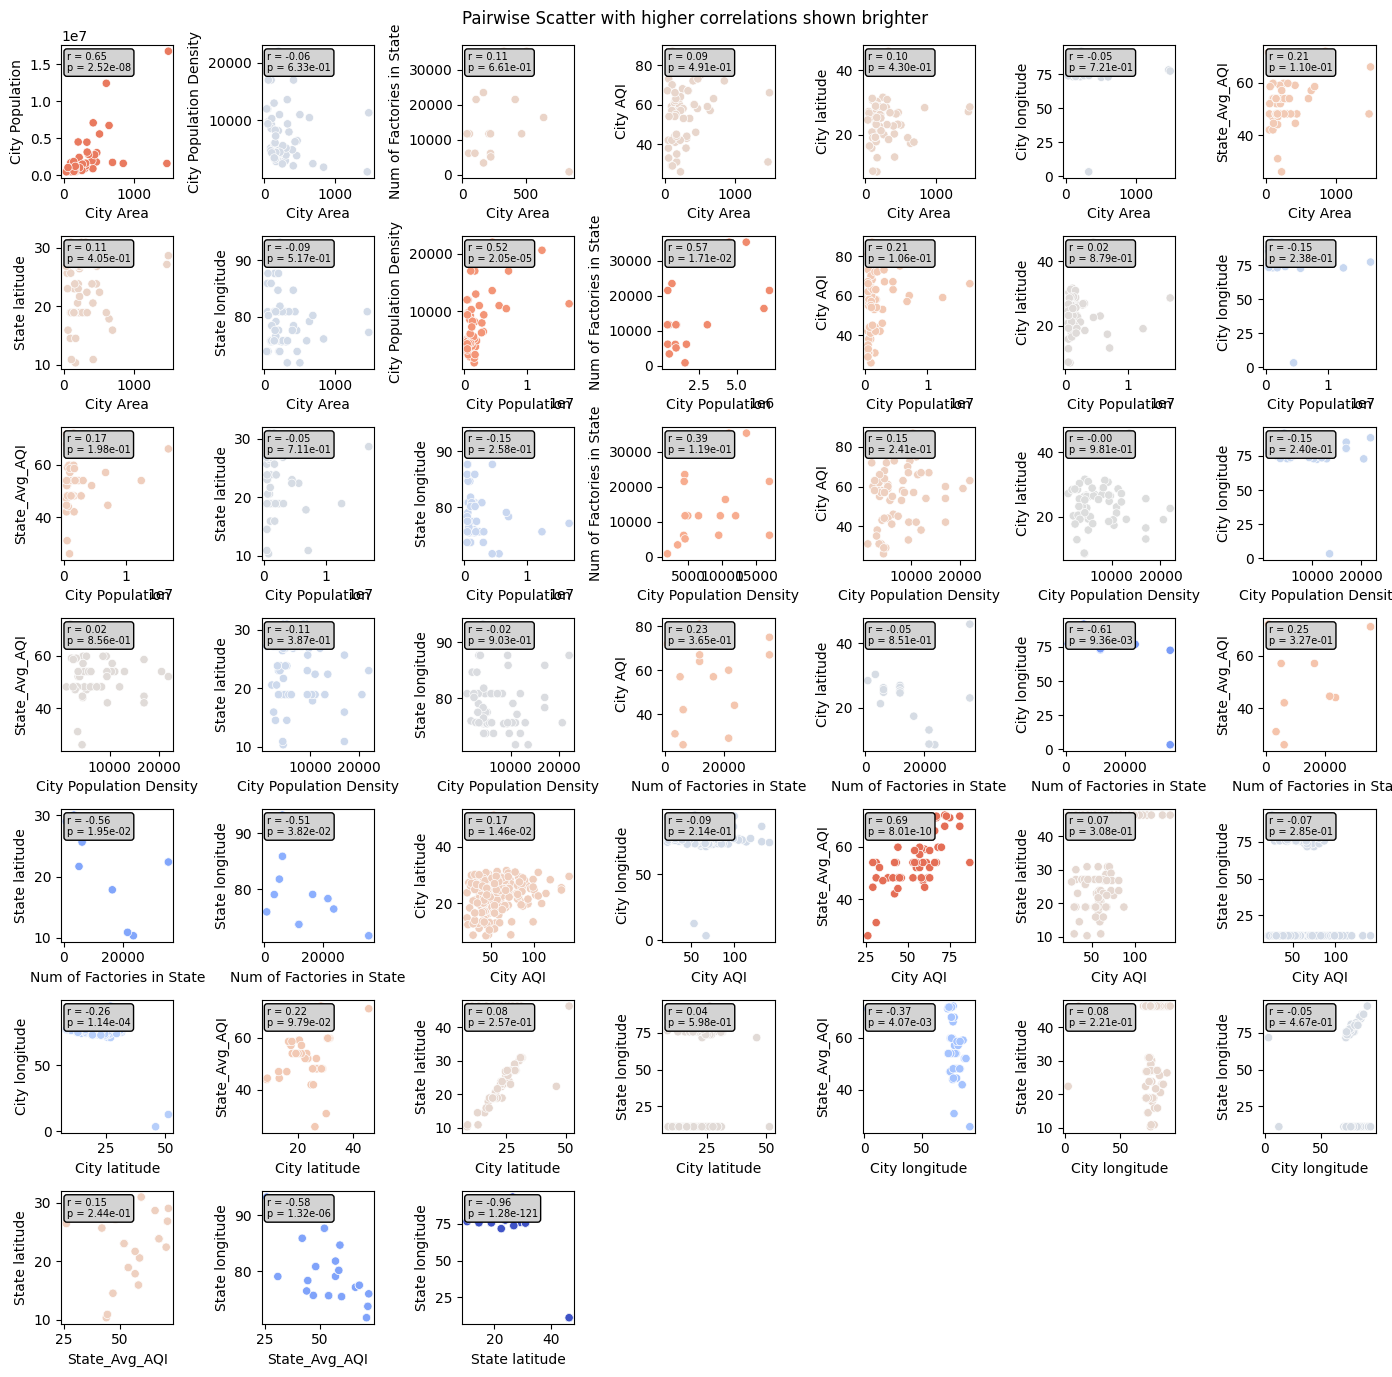

In [ ]:
Plotsgrid(df).scatterplots()

<li>There is a weak correlation between City AQI and City Population and Population Density. 
<li> There is also a weak correlation between City and State AQI and number of factories in State
<li> This suggests that industrialization could be a significant factor to bad air quality
<li> This also gives another insight - highly industrialized areas tend to be more populous - This could exacerbate air quality issues caused by other human activities as well
<li>The strong correlation with State AQI is expected since the city AQI contributes to state AQI

In [67]:
# Get dataframe of City, Population, Latitude, Longitude
df_city_population=df[['City','City Population','City latitude','City longitude','City AQI']].dropna()
# Let's use Logarithm scaling to reduce the effect of outliers
df_city_population['City Population']=np.log(df_city_population['City Population'])
df_city_population.info()

<class 'pandas.core.frame.DataFrame'>
Index: 60 entries, 1 to 211
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   City             60 non-null     object 
 1   City Population  60 non-null     float64
 2   City latitude    60 non-null     float64
 3   City longitude   60 non-null     float64
 4   City AQI         60 non-null     int32  
dtypes: float64(3), int32(1), object(1)
memory usage: 2.6+ KB


In [50]:
# Add States location information to df
state_loc={}
states=df.State.tolist()
for state in states:
    try:
        loc = geolocator.geocode(state)
        state_loc[state]=(loc.latitude,loc.longitude)
    except Exception as E:
        print(E)
        state_loc[state]=(np.nan,np.nan)
        
df['State latitude']=df['State'].apply(lambda x:state_loc[x][0])
df['State longitude']=df['State'].apply(lambda x:state_loc[x][1])

In [51]:
df.head()

,City,State,City Area,City Population,City Population Density,Num of Factories in State,City AQI,City latitude,City longitude,State_Avg_AQI,State latitude,State longitude
0,Agartala,NaN,NaN,NaN,NaN,NaN,36,23.831238,91.282382,NaN,46.314475,11.048029
1,Agra,Uttar Pradesh,1462.0,1585704.0,1084.0,NaN,31,27.175255,78.009816,48.083333,27.130334,80.859666
2,Ahmedabad,Gujarat,507.0,5577940.0,11000.0,35339.0,75,23.021537,72.580057,71.000000,22.385005,71.745261
3,Ahmednagar,NaN,NaN,NaN,NaN,NaN,38,19.162773,74.858024,NaN,46.314475,11.048029
4,Aizawl,NaN,NaN,NaN,NaN,NaN,22,23.743353,92.738276,NaN,46.314475,11.048029


In [52]:
df_states_fac=df.dropna(subset=['Num of Factories in State'])

In [71]:
maps={}
map_clusters = folium.Map(location=[latitude, longitude],zoom_start=5)

# Define a colormap using matplotlib
colormap = plt.get_cmap('YlOrRd')  # You can choose any colormap from matplotlib

# Normalize index values to range [0, 1] for the colormap
norm = Normalize(vmin=df_city_population['City Population'].min(), vmax=df_city_population['City Population'].max())

# add markers to the map
markers_colors = []

for index,row in df_city_population.iterrows():

    name,pop,lat,lon,aqi=row['City'],row['City Population'],row['City latitude'],row['City longitude'],row['City AQI']
    label = folium.Popup(f"{name}, Population: {pop}, AQI: {aqi}",parse_html=True)

    # Get color from colormap
    rgba_color = colormap(norm(pop))  # This returns an RGBA tuple
    hex_color = colors.rgb2hex(rgba_color[:3])  # Convert to hex

    folium.RegularPolygonMarker(
        [lat, lon],
        radius=5,
        number_of_sides=5,
        popup=label,
        color=hex_color,
        fill=True,
        fill_color=hex_color,
        fill_opacity=0.7,
                        ).add_to(map_clusters)
    
# Define a colormap using matplotlib
colormap = plt.get_cmap('PuBu')  # You can choose any colormap from matplotlib

# Normalize index values to range [0, 1] for the colormap
norm = Normalize(vmin=df_states_fac['Num of Factories in State'].min(), vmax=df_states_fac['Num of Factories in State'].max())

# add markers to the map
markers_colors = []
    
for index,row in df_states_fac.iterrows():

    name,fac,lat,lon,state_avg_aqi=row['State'],row['Num of Factories in State'],row['State latitude'],row['State longitude'],row['State_Avg_AQI']
    label = folium.Popup(f"{name}, Num of Factories in State: {fac}, State_Avg_AQI: {state_avg_aqi}",parse_html=True)

    # Get color from colormap
    rgba_color = colormap(norm(fac))  # This returns an RGBA tuple
    hex_color = colors.rgb2hex(rgba_color[:3])  # Convert to hex

    folium.CircleMarker(
        [lat, lon],
        radius=10,
        popup=label,
        color='hex_color',
        fill=True,
        fill_color=hex_color,
        fill_opacity=0.3,
                        ).add_to(map_clusters)

map_clusters


<b> Concluding Remarks </b>
<li>The most populated areas, especially the four major metros as well as cities like Ahmedabad and Hyderabad have higher AQIs.
<li> This trend of populated areas having high AQIs are observed throughout India
<li> A combination of industrialization and other population related effects could be the causes of air pollution. 
<li> Other factors that can be explored: Motor vehicles, electric vehicles, outdoor burning, combination of factors
